# Regresión logística

## Introducción

El objetivo de este archivo es mostrar el desarrollo de regresión logística en el marco de machine learning y el modelo lineal general.

Cuando hablamos de regresión logística nos referimos a una tarea de predicción de una variable con múltiples categorías, lo cual es conocido como un problema de clasificación. En particular en este libro de notas nos restringiremos a la regresión logística binaria, en la que los posibles resultados de la variable predictora son solo dos, y se puede pensar en que la respuesta es una variable binomial.

##Data and business understanding

Trabajaremos con el contexto del archivo de cartera de empresas. Para mantener los libros de nota modulares, repetiré aquí el contexto:

In [3]:
if (!require('caret')) install.packages('caret')
if (!require('ROCR')) install.packages('ROCR')

Loading required package: caret

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘caret’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’


Loading required package: ROCR

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ROCR’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’, ‘gplots’




In [4]:
library(caret)
library(ROCR)
library(ggplot2)
library(readxl)

Loading required package: ggplot2

Loading required package: lattice



In [93]:
cartera<-read_excel("carteraguia2017.xlsx")
str(cartera)

tibble [852 × 9] (S3: tbl_df/tbl/data.frame)
 $ MESES                   : num [1:852] 41 27 40 41 24 41 39 43 24 36 ...
 $ TIPO_ips                : num [1:852] 3 1 1 1 2 2 1 1 1 1 ...
 $ IGUAL_DUENO             : num [1:852] 17 10 15 15 2 5 20 12 3 0 ...
 $ AGNOS_DIRECCION_ACTUAL  : num [1:852] 12 6 14 14 0 5 9 11 4 13 ...
 $ VENTAS_MENS_PROMEDIO    : num [1:852] 176 31 55 120 28 25 67 38 19 25 ...
 $ PORC_PASIVOS_VENTA_ANUAL: num [1:852] 9.3 17.3 5.5 2.9 17.3 10.2 30.6 3.6 24.4 19.7 ...
 $ cartera_actual_insumos_A: num [1:852] 11.359 1.362 0.856 2.659 1.787 ...
 $ cartera_actual_insumos_B: num [1:852] 5.009 4.001 2.169 0.821 3.057 ...
 $ retrasos                : num [1:852] 1 0 0 0 1 0 0 0 1 0 ...


El archivo contiene datos de clientes de un proveedor de instituciones de salud (IPS), la cartera que presentan y si se han retrasado o no. Se trata entonces de un negocio B2B en el sector de la salud que desea predecir o averiguar indicadores de posibles aumentos y retrasos en su cartera

Entre las variables predictoras se incluyen:


*   Tipo_IPS: De 1 a5, el nivel de complejidad de la institución de salud cliente (1=bajo, 5=alto)

*   MESES: Los meses que la empresa lleva siendo clientes del proveedor.

*   IGUAL_DUEÑO: Número de años en que la IPS ha tenido el mismo dueño.

*   AGNOS_DIRECCION_ACTUAL: Número de años en que la IPS ha estado en la misma dirección.

*   VENTAS_MENS_PROMEDIO: Valor de ventas mensuales promedio de la IPS en millones de pesos.

*   PORC_PASIVOS_VENTA_ANUAL: Porcentaje de pasivos/ venta anual del último balance disponible.


*   CARTERA_ACTUAL_INSUMOS_A: Valor de la deuda con el proveedor en insumos de alta rotación (gasa, jeringas, por ejemplo) en millones de pesos.

*   CARTERA_ACTUAL_INSUMOS_B: Valor de la deuda con el proveedor en insumos de baja rotación (equipos, instrumentos, por ejemplo) en millones de pesos.



La variable a predecir son los RETRASOS, que indican sí el cliente se ha retrasado o no, siendo 1=sí y 0=No.

##Data preparation

Primero vamos a convertir a factores las dos variables que lo requieren: Tipo IPS y retrasos. También vamos a crear variables binarias para los tipos de IPS y luego retirar la variable TIPO IPS.

In [94]:
cartera$TIPOips<-as.factor(cartera$TIPO_ips)

In [95]:
carterawin<-dummyVars("~.",data=cartera)
carterafin<-as.data.frame(predict(carterawin,newdata=cartera))
carterafin2<-within(carterafin,rm(TIPOips.5,TIPO_ips))
carterafin2$retrasos<-as.factor(carterafin2$retrasos)
str(carterafin2)

'data.frame':	852 obs. of  12 variables:
 $ MESES                   : num  41 27 40 41 24 41 39 43 24 36 ...
 $ IGUAL_DUENO             : num  17 10 15 15 2 5 20 12 3 0 ...
 $ AGNOS_DIRECCION_ACTUAL  : num  12 6 14 14 0 5 9 11 4 13 ...
 $ VENTAS_MENS_PROMEDIO    : num  176 31 55 120 28 25 67 38 19 25 ...
 $ PORC_PASIVOS_VENTA_ANUAL: num  9.3 17.3 5.5 2.9 17.3 10.2 30.6 3.6 24.4 19.7 ...
 $ cartera_actual_insumos_A: num  11.359 1.362 0.856 2.659 1.787 ...
 $ cartera_actual_insumos_B: num  5.009 4.001 2.169 0.821 3.057 ...
 $ retrasos                : Factor w/ 2 levels "0","1": 2 1 1 1 2 1 1 1 2 1 ...
 $ TIPOips.1               : num  0 1 1 1 0 0 1 1 1 1 ...
 $ TIPOips.2               : num  0 0 0 0 1 1 0 0 0 0 ...
 $ TIPOips.3               : num  1 0 0 0 0 0 0 0 0 0 ...
 $ TIPOips.4               : num  0 0 0 0 0 0 0 0 0 0 ...


Si se desea se puede realizar una exploración básica de las variables independientes antes de separarlas en bases de entrenamiento y validación, lo que se deja al lector.

De todos modos, es importante ver la proporción de retrasos vs. no retrasos. En caso de que una de las clases, usualmente la clase que más interesa predecir, tenga un porcentaje mucho menor que la otra (digamos, menos del 20%) es necesario un balanceo de la base de datos.

In [96]:
balance<-table(cartera$retrasos)
prop.table(balance)


        0         1 
0.7734742 0.2265258 

Incialmente no es necesario un balanceo, pero podemos considerarlo más adelante si queremos que el algoritmo “aprenda” más sobre los retrasos.

Creemos bases de entrenamiento y validación

In [97]:
set.seed(1)
#aquí se define el tamaño de la muestra, en este caso entrenamiento tendrá el 75% de los casos

In [98]:
sample <- sample.int(nrow(carterafin2), floor(.75*nrow(carterafin2)))
cartera.train <- carterafin2[sample, ]
cartera.test <- carterafin2[-sample, ]

In [99]:
str(cartera.train)

'data.frame':	639 obs. of  12 variables:
 $ MESES                   : num  28 40 21 25 21 25 39 40 36 35 ...
 $ IGUAL_DUENO             : num  10 6 5 9 2 4 19 14 11 10 ...
 $ AGNOS_DIRECCION_ACTUAL  : num  1 9 1 2 0 5 16 21 12 16 ...
 $ VENTAS_MENS_PROMEDIO    : num  42 36 25 20 20 27 45 43 44 39 ...
 $ PORC_PASIVOS_VENTA_ANUAL: num  8.6 2.1 9 3.5 4.5 5 3.7 15 14.7 5.7 ...
 $ cartera_actual_insumos_A: num  1.047 0.391 0.367 0.105 0.291 ...
 $ cartera_actual_insumos_B: num  2.565 0.365 1.883 0.595 0.609 ...
 $ retrasos                : Factor w/ 2 levels "0","1": 1 2 1 1 2 2 1 2 1 1 ...
 $ TIPOips.1               : num  1 1 1 1 0 0 1 1 0 1 ...
 $ TIPOips.2               : num  0 0 0 0 1 1 0 0 0 0 ...
 $ TIPOips.3               : num  0 0 0 0 0 0 0 0 1 0 ...
 $ TIPOips.4               : num  0 0 0 0 0 0 0 0 0 0 ...


## Modelling

Ahora podemos hacer un modelo de regresión logística basado en pasos sucesivos:

In [100]:
##Modelo
set.seed(1)
modelo.logit<-glm(retrasos~.,family=binomial,cartera.train)
#trace=0 impide ver todos los detalles de la optimización stepwise
steplogit<-step(modelo.logit, direction="both")
summary(steplogit)

Start:  AIC=510.69
retrasos ~ MESES + IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + VENTAS_MENS_PROMEDIO + 
    PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A + cartera_actual_insumos_B + 
    TIPOips.1 + TIPOips.2 + TIPOips.3 + TIPOips.4

                           Df Deviance    AIC
- cartera_actual_insumos_B  1   486.88 508.88
- TIPOips.3                 1   487.36 509.36
- TIPOips.2                 1   487.40 509.40
- TIPOips.1                 1   487.68 509.68
- MESES                     1   487.85 509.85
- VENTAS_MENS_PROMEDIO      1   487.98 509.98
- TIPOips.4                 1   488.34 510.34
<none>                          486.69 510.69
- AGNOS_DIRECCION_ACTUAL    1   494.80 516.80
- PORC_PASIVOS_VENTA_ANUAL  1   497.78 519.78
- cartera_actual_insumos_A  1   519.74 541.74
- IGUAL_DUENO               1   540.85 562.85

Step:  AIC=508.88
retrasos ~ MESES + IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + VENTAS_MENS_PROMEDIO + 
    PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A + TIPOi


Call:
glm(formula = retrasos ~ IGUAL_DUENO + AGNOS_DIRECCION_ACTUAL + 
    PORC_PASIVOS_VENTA_ANUAL + cartera_actual_insumos_A + TIPOips.4, 
    family = binomial, data = cartera.train)

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.36811    0.27505  -4.974 6.55e-07 ***
IGUAL_DUENO              -0.22511    0.03003  -7.495 6.62e-14 ***
AGNOS_DIRECCION_ACTUAL   -0.05355    0.02070  -2.587  0.00968 ** 
PORC_PASIVOS_VENTA_ANUAL  0.11783    0.01952   6.036 1.58e-09 ***
cartera_actual_insumos_A  0.46515    0.08036   5.789 7.09e-09 ***
TIPOips.4                -0.79677    0.49327  -1.615  0.10625    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 701.13  on 638  degrees of freedom
Residual deviance: 490.15  on 633  degrees of freedom
AIC: 502.15

Number of Fisher Scoring iterations: 6


Los coeficientes de la regresión logística pueden ser sujeto de interpretación en términos de odd ratios.

In [101]:
coeficientes<-steplogit$coefficients
odd_change<-exp(coeficientes)
odd_change_ver<-as.data.frame(odd_change)
odd_change_ver

,odd_change
,<dbl>
(Intercept),0.2545877
IGUAL_DUENO,0.7984315
AGNOS_DIRECCION_ACTUAL,0.9478609
PORC_PASIVOS_VENTA_ANUAL,1.1250584
cartera_actual_insumos_A,1.5922555
TIPOips.4,0.4507826


### odd ratios

Los coeficientes, denominados odd ratios indican que:

Cada año con el mismo dueño, dejando todas las demás variables constantes, reduce al 79.84% el odd base de que el cliente incumpla, es decir, reduce la probabilidad de incumplimiento (la reducción exacta en probabilidad la veremos más adelante).

Cada año en la dirección actual reduce el odd base al 94.78%.

En la otra dirección están las variables que aumentan el incumplimiento: Por cada punto porcentual de pasivo/venta anual aumenta el odd base en 12.5%, mientras que cada millon que le adeudan al proveedor en cartera de baja rotación (A) aumenta el odd base de incumplimiento en 59.22%.

Para entender mejor los odd ratios es necesario primero tener clara la tasa base. Ese valor es la proporción de éxitos en la base de datos (en este caso siendo éxito un retraso). Esto ya lo obtuvimos en la tabla vista previamente y que aquí repetimos. De allí, podemos calcular un odd base.

In [102]:
#Odd ratios
balance<-table(cartera$retrasos)
prop.table(balance)
oddbase<-prop.table(balance)[2]/prop.table(balance)[1]
oddbase


        0         1 
0.7734742 0.2265258 

1 
0.292868

Si el odd base es de 0.29 (y la probabilidad inicial de incumplimiento de 22.65%), podemos multiplicar los odd ratios por esa tase base y luego convertirla a probabilidad:

In [103]:
oddfin<-oddbase*odd_change
prob1step<-as.data.frame(oddfin/(1+oddfin))
View(prob1step)

,oddfin/(1 + oddfin)
,<dbl>
(Intercept),0.06938705
IGUAL_DUENO,0.18951887
AGNOS_DIRECCION_ACTUAL,0.21728125
PORC_PASIVOS_VENTA_ANUAL,0.24783390
cartera_actual_insumos_A,0.31802093
TIPOips.4,0.11662321


De ese modo vemos que aumentar un año el cliente en la dirección actual (con todo lo demás constante) reduce la probabilidad de incumplimiento al 18.95%, mientras que el primer millón adicional de cartera en insumos A la aumenta al 33.43%.

## Evaluación

Para la evaluación de un problema de clasificación se utilizan con mucha frecuencia las matrices de confusión, que permiten ver la precision y la exhaustividad (precision and recall)

Las haremos suponiendo que una predicción superior a 0.5 indica incumplimiento, y una predicción inferior o igual a 0.5 indica cumplimiento

In [16]:
steplogit$fitted.values

836          679          129          509          471          299 
0.1022839515 0.0588885433 0.2114713713 0.0456556728 0.2399697662 0.1555761246 
         270          187          307          597          277          494 
0.0035405235 0.0706025845 0.0726229159 0.0240579828 0.5489094477 0.9710070730 
         330          775          591          725           37          105 
0.1516278220 0.6059525178 0.1984787773 0.0002475054 0.2174673857 0.5360049092 
         729          485          677          802          382          601 
0.0394558966 0.0942399161 0.0009833368 0.3338997813 0.7517040311 0.9690192491 
         801          326          840          554          422          111 
0.4376445089 0.9066786474 0.0083798187 0.6215069752 0.4969926122 0.2149518342 
         404          532          506          556          343          582 
0.2497621011 0.2526930898 0.7029602214 0.0023769980 0.0067696367 0.2006913659 
         121           40          684          537          375          248 
0.0361289567 0.0023323414 0.1425411332 0.1901335367 0.0015669456 0.3905111978 
         198          378           39          435          390          280 
0.0172197896 0.3245481613 0.6492422223 0.5515011580 0.0265434618 0.0819025919 
         672          526          642           45          402           22 
0.2212235869 0.2435353078 0.1395395856 0.4149144014 0.4144673944 0.0045583109 
         718          742          193          371          499          104 
0.8699502245 0.5144440819 0.1278444288 0.0531481781 0.1072815762 0.0033885089 
         827          767          492          616          615          465 
0.4445924083 0.0382672652 0.0114279312 0.0793164335 0.0095293182 0.0769782505 
         525          834          176          345          110           84 
0.0049023881 0.0089199444 0.2368795682 0.1243411492 0.0847123407 0.1457633541 
          29          141          252          733          620          304 
0.2900840545 0.7066822879 0.3355914220 0.0091715445 0.4333688463 0.1031399334 
         545          557          661          287          614          145 
0.7932868902 0.0944118374 0.1671901298 0.0439088714 0.4780984414 0.0064614080 
         329          487          630          498          619          576 
0.2677161554 0.1352284561 0.6613494573 0.0880611600 0.0925082891 0.9111364422 
         490          736          103          316           51          777 
0.6127887658 0.0236958969 0.0759249131 0.3119402609 0.3416493937 0.2437188119 
         290          650          850          282          143          442 
0.0446473473 0.0107960435 0.2556037157 0.5232362762 0.0064620007 0.1051890824 
         285          682           48          501          716          511 
0.2212653891 0.6186936519 0.2509510916 0.8427275424 0.1822793958 0.0067825854 
         295          536          693          214          737          339 
0.1677758683 0.3000277814 0.0266861499 0.1483594294 0.1582309786 0.8555606484 
         346          675           43            1          780          590 
0.6106520489 0.5767292032 0.0393300086 0.6323288537 0.1620617093 0.0729028806 
         628          233          293          573          369          451 
0.1334995138 0.0190522054 0.0021143949 0.1979367963 0.1050493696 0.6933867452 
          86          483          327          622          355           49 
0.2191694867 0.3957919228 0.2590441192 0.3218507795 0.3021027148 0.5569792059 
         361          759          242          440          247          219 
0.0125396836 0.3659723951 0.1059985767 0.0844687537 0.0048477667 0.0634060325 
         135          823          821          377          408          758 
0.1123720894 0.1548899185 0.2276045459 0.0339637071 0.0673704916 0.4755876454 
         565          467          356          130           65          359 
0.0181164123 0.7285364111 0.2005617007 0.0125181648 0.1865011237 0.5075345054 
         835          124           77          218        

In [104]:
#crea el pronostico base de entrenamiento
prontrain<-ifelse(steplogit$fitted.values > 0.5,1,0)
#tabla de confusión y estadisticas, base de entrenamiento
conftrain<-confusionMatrix(as.factor(prontrain),cartera.train$retrasos, positive = "1")
conftrain

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 455  83
         1  32  69
                                         
               Accuracy : 0.82           
                 95% CI : (0.788, 0.8491)
    No Information Rate : 0.7621         
    P-Value [Acc > NIR] : 0.0002424      
                                         
                  Kappa : 0.4389         
                                         
 Mcnemar's Test P-Value : 3.124e-06      
                                         
            Sensitivity : 0.4539         
            Specificity : 0.9343         
         Pos Pred Value : 0.6832         
         Neg Pred Value : 0.8457         
             Prevalence : 0.2379         
         Detection Rate : 0.1080         
   Detection Prevalence : 0.1581         
      Balanced Accuracy : 0.6941         
                                         
       'Positive' Class : 1              
                                         

In [105]:
#crea el pronóstico en validación
probtest<-predict(steplogit,newdata = cartera.test,type='response')
prontest<-ifelse(probtest > 0.5,1,0)
conftest<-confusionMatrix(as.factor(prontest),cartera.test$retrasos, positive = "1")
conftest

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 161  20
         1  11  21
                                          
               Accuracy : 0.8545          
                 95% CI : (0.7998, 0.8989)
    No Information Rate : 0.8075          
    P-Value [Acc > NIR] : 0.04585         
                                          
                  Kappa : 0.4891          
                                          
 Mcnemar's Test P-Value : 0.15076         
                                          
            Sensitivity : 0.51220         
            Specificity : 0.93605         
         Pos Pred Value : 0.65625         
         Neg Pred Value : 0.88950         
             Prevalence : 0.19249         
         Detection Rate : 0.09859         
   Detection Prevalence : 0.15023         
      Balanced Accuracy : 0.72412         
                                          
       'Positive' Class : 1               
                              

En la base de datos de validación, la precisión es del 63.63% y la exhaustividad de 30.34%. La precisión es qué tanto acierta el modelo cuando dice que una empresa generará incumplimiento. La exhaustividad es cuántas de las empresas incumplidas son detectadas como tales.UNa combinación de los dos es el F1 score, que para nuestro caso es de 41.17%. Se puede aumentar la precisión disminuyendo la exhaustividad y viceversa, cambiando simplemente el punto de corte (disminuyéndolo para aumentar precisión o aumentándolo para aumentar exhaustividad)

Para observar ese balance se utiliza la curva COR (o ROC por sus siglas en inglés). Al graficar la curva de todas las posibles combinaciones de falsos positivos (que hablan de la precisión) contra los verdaderos positivos (que hablan de la exhaustividad) podemos darnos una idea de cómo funcionaría el modelo en diferentes puntos de corte. El área bajo la curva dibujada es un indicador adicional de la calidad del modelo

In [19]:
##nuevo sobre precision
cartllev<-cbind(cartera.test,probtest)

In [20]:
cartllev

,MESES,IGUAL_DUENO,AGNOS_DIRECCION_ACTUAL,VENTAS_MENS_PROMEDIO,PORC_PASIVOS_VENTA_ANUAL,cartera_actual_insumos_A,cartera_actual_insumos_B,retrasos,TIPOips.1,TIPOips.2,TIPOips.3,TIPOips.4,probtest
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,24,3,4,19,24.4,1.358348,3.277652,1,1,0,0,0,0.777194643
10,36,0,13,25,19.7,2.777700,2.147300,0,1,0,0,0,0.824794255
14,37,6,9,29,16.3,1.715901,3.011099,0,1,0,0,0,0.381824775
18,43,23,19,72,7.6,1.181952,4.290048,0,1,0,0,0,0.002198848
23,28,3,6,26,10.0,0.431600,2.168400,0,1,0,0,0,0.271781209
24,29,8,6,27,9.8,0.402192,2.243808,0,1,0,0,0,0.104482614
32,30,1,10,22,10.5,1.138830,1.171170,0,1,0,0,0,0.410549271
38,32,12,1,54,14.4,3.195936,4.580064,0,0,1,0,0,0.280998752
46,21,0,1,16,6.8,0.150144,0.937856,0,0,1,0,0,0.365739140


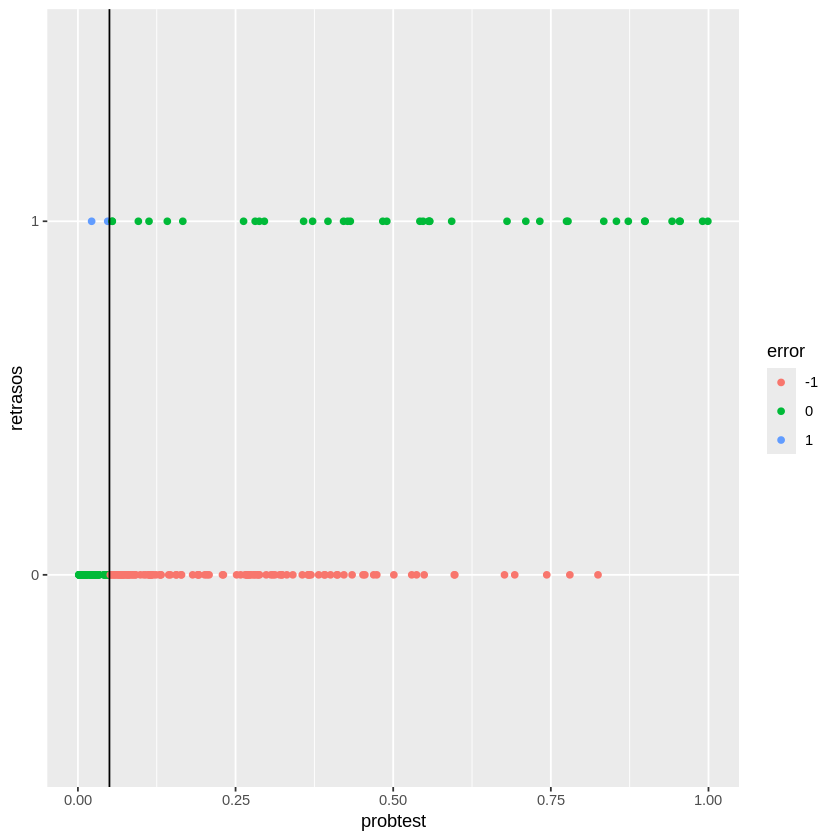

In [21]:
corte<-0.05
cartllev$pronostico<-as.factor(ifelse(cartllev$probtest>corte,1,0))
cartllev$error<-as.factor(as.numeric(cartllev$retrasos)-as.numeric(cartllev$pronostico))
ggplot(cartllev,aes(probtest,retrasos, color=error))+geom_point()+geom_vline(xintercept=corte)

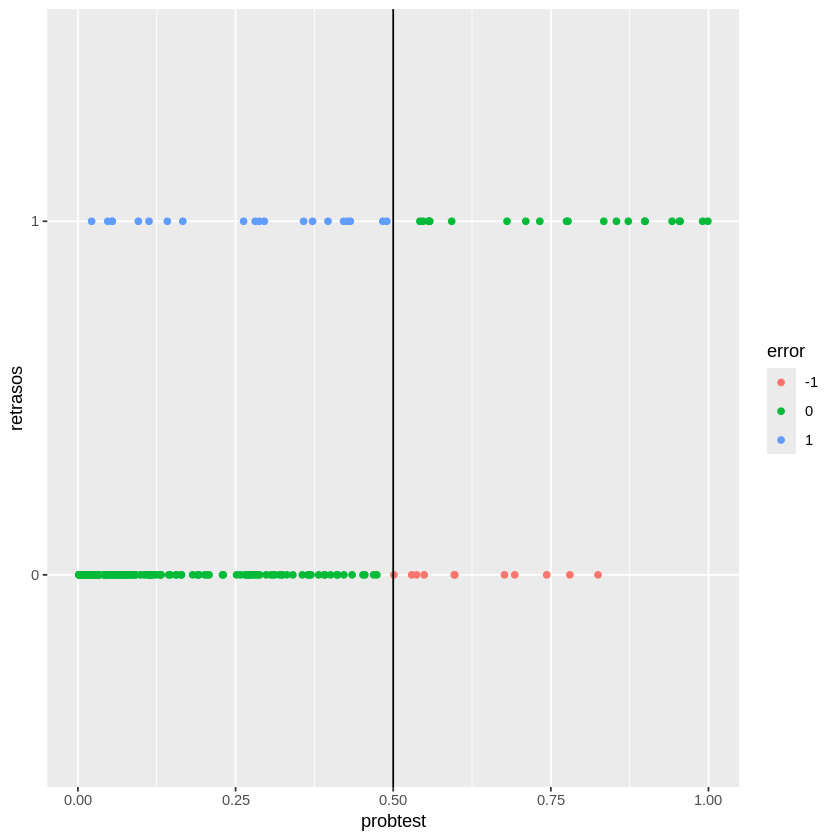

In [22]:
corte<-0.5
cartllev$pronostico<-as.factor(ifelse(cartllev$probtest>corte,1,0))
cartllev$error<-as.factor(as.numeric(cartllev$retrasos)-as.numeric(cartllev$pronostico))
ggplot(cartllev,aes(probtest,retrasos, color=error))+geom_point()+geom_vline(xintercept=corte)

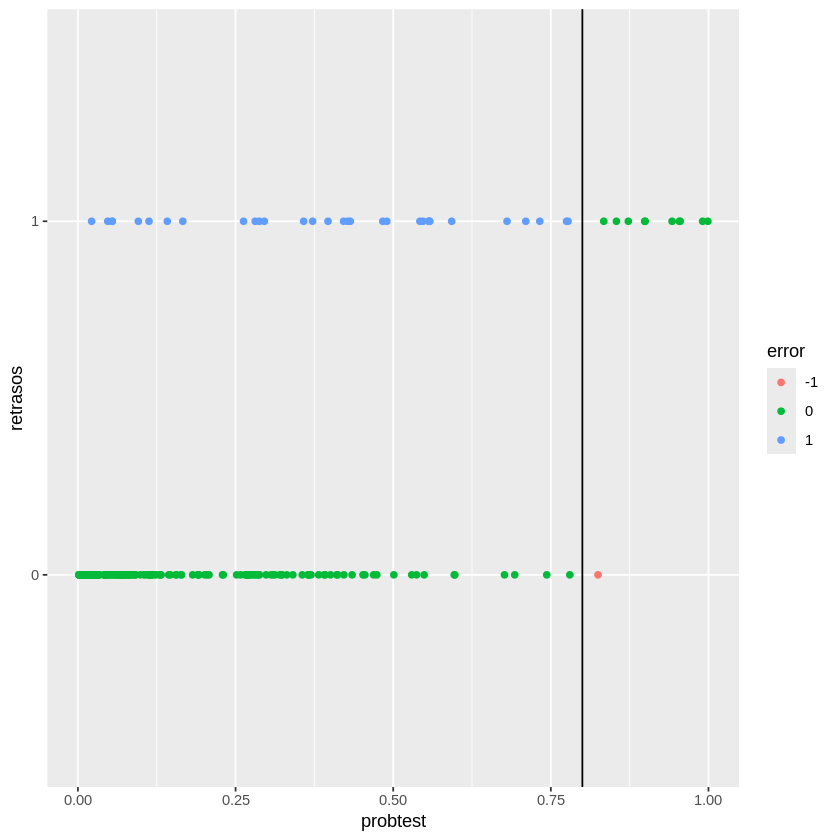

In [23]:
corte<-0.8
cartllev$pronostico<-as.factor(ifelse(cartllev$probtest>corte,1,0))
cartllev$error<-as.factor(as.numeric(cartllev$retrasos)-as.numeric(cartllev$pronostico))
ggplot(cartllev,aes(probtest,retrasos, color=error))+geom_point()+geom_vline(xintercept=corte)

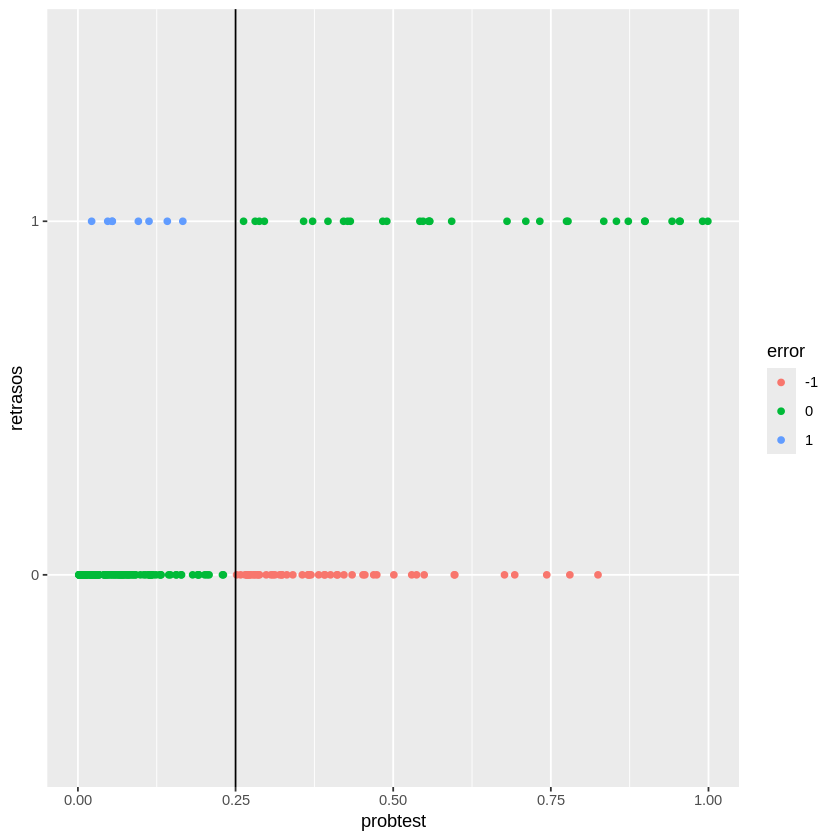

In [24]:
corte<-0.25
cartllev$pronostico<-as.factor(ifelse(cartllev$probtest>corte,1,0))
cartllev$error<-as.factor(as.numeric(cartllev$retrasos)-as.numeric(cartllev$pronostico))
ggplot(cartllev,aes(probtest,retrasos, color=error))+geom_point()+geom_vline(xintercept=corte)

In [25]:
#crear objeto de predicciones
pr<-prediction(probtest,cartera.test$retrasos)
#creacion del objeto de la curva
curvaROC<-performance(pr,measure="tpr",x.measure="fpr")

[1] 0.8418888

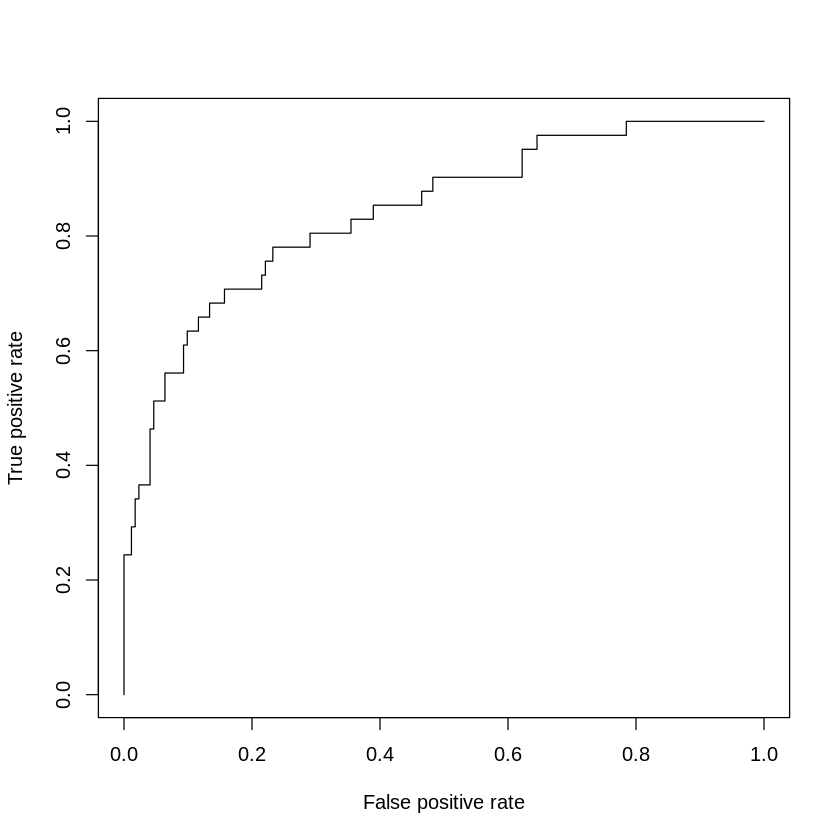

In [75]:
#grafico de la curva
plot(curvaROC)
#calcular el AUC
auc<-performance(pr,measure = "auc")
auc <- auc@y.values[[1]]
#ver el AUC
auc

El area bajo la curva es de 84.18%, lo cual está bien por encima del 50% de una predicción al azar.

•	La curva ROC ranquea todos las empresas desde el que tiene la probabilidad más alta de rechazo hasta la más baja (equivale a variar el umbral desde alto hasta bajo). Comenzando en el origen, mapea todos las empresas en orden descendiente de probabilidad (desde el “mejor” hasta el “peor”). Un clasificador perfecto, con exactitud 100%, primero predeciría correctamente todos los positivos, y luego predeciría correctamente todos los negativos; es decir, la curva iría recto hasta el punto (0,1), y luego cambiaría y sería horizontal hasta el punto (1,1). Esto, por supuesto, no es posible en la práctica, y los “pasos” en la curva reflejan los errores ocasionales que el modelo comete. Un buen modelo cometería pocos errores positivos para los mejores clientes y pocos eroreres negativos para los peores.

•	Es importante observar que un modelo que simplemente adivina al azar, tendrá como curva ROC una línea de 45 grados. Tal modelo tendría la misma probabilidad de hacer una predicción correcta que una incorrecta, sin importar si el cliente tiene una alta o baja probabilidad predecida.

•	En este caso el AUC es 84.18% el cual es un buen resultado. El AUC indica la proporción de parejas concordantes en los datos; en este caso el porcentaje de parejas concordantes es aproximadamente 84.18%. Las parejas concordantes son aquellas parejas de casos positivo y negativo en el dataset para las cuales el modelo de Regresión logística puede clasificarlos correctamente.

•	En el dataset de prueba, tenemos 41 positivos (empresas rechazadas) y 172 negativos (empresas sin rechazo); el número total de parejas (positivos y negativos) es 41 x 172 = 7052, de los cuales 84.18% (== 5945) tienen unos parámetros del modelo de Regresión Logística que pueden clasificarlos correctamente.


La curva COR muestra que para lograr un 80% de exhaustividad (tomar acciones sobre el 80% de los incumplidos), tendríamos que aceptar casi un 30% de falsos positivos (en lenguaje de negocios, tendríamos que “tocar o incomodar” al 30% de clientes que van a ser cumplidos)

La tabla completa puede obtenerse de la siguiente manera:

In [77]:
fprs<-unlist(curvaROC@x.values)
tprs<-unlist(curvaROC@y.values)
tablaCOR<-as.data.frame(cbind(fprs,tprs))
tablaCOR[70:90,]

,fprs,tprs
,<dbl>,<dbl>
70,0.2209302,0.7560976
71,0.2267442,0.7560976
72,0.2325581,0.7560976
73,0.2325581,0.7804878
74,0.2383721,0.7804878
75,0.2441860,0.7804878
76,0.2500000,0.7804878
77,0.2558140,0.7804878
78,0.2616279,0.7804878


## Evaluación financiera

Los valores de capacidad predictiva (y de error) deben ser vistos a la luz del negocio. Eso significa, usualmente, traducirlos en términos de costo/beneficio.

Ahi suele ser clave trabajar para maximizar la ganancia.

Para ello es importante definir los beneficios que nos trae un acierto y las pérdidas que nos genera un error.

Supongamos que un acierto nos permite ahorros de 500 (mil pesos) y en cambio un fracaso nos hace dejar de ganar aproximadamente 100 (mil pesos). Vamos a suponer que el porcentaje de éxitos posibles es similar al de la base de datos completa.

Podemos crear una base de precisiones y exhaustividades que, basadas en la ecuación vista en clase, nos permitan calcular ganancias para diferentes puntos de corte:

In [78]:
#guardar las exhaustividades y puntos de corte
tablafinan<-performance(pr,measure="rec")
cutoffs<-unlist(tablafinan@x.values)
recalls<-unlist(tablafinan@y.values)

In [79]:
#guardar las precisiones
tablafina2<-performance(pr,measure="prec")
precisions<-unlist(tablafina2@y.values)

In [80]:
#guardar f scores
tablafina3<-performance(pr,measure="f")
fscores<-unlist(tablafina3@y.values)

In [81]:
#crear la tabla conjunta
tablacruce<-as.data.frame(cbind(cutoffs,precisions,recalls,fscores))
tablacruce

,cutoffs,precisions,recalls,fscores
,<dbl>,<dbl>,<dbl>,<dbl>
,Inf,NaN,0.00000000,NaN
374,0.9989969,1.0000000,0.02439024,0.04761905
805,0.9907266,1.0000000,0.04878049,0.09302326
468,0.9551019,1.0000000,0.07317073,0.13636364
344,0.9538976,1.0000000,0.09756098,0.17777778
90,0.9422966,1.0000000,0.12195122,0.21739130
95,0.8995960,1.0000000,0.14634146,0.25531915
608,0.8988386,1.0000000,0.17073171,0.29166667
694,0.8728423,1.0000000,0.19512195,0.32653061


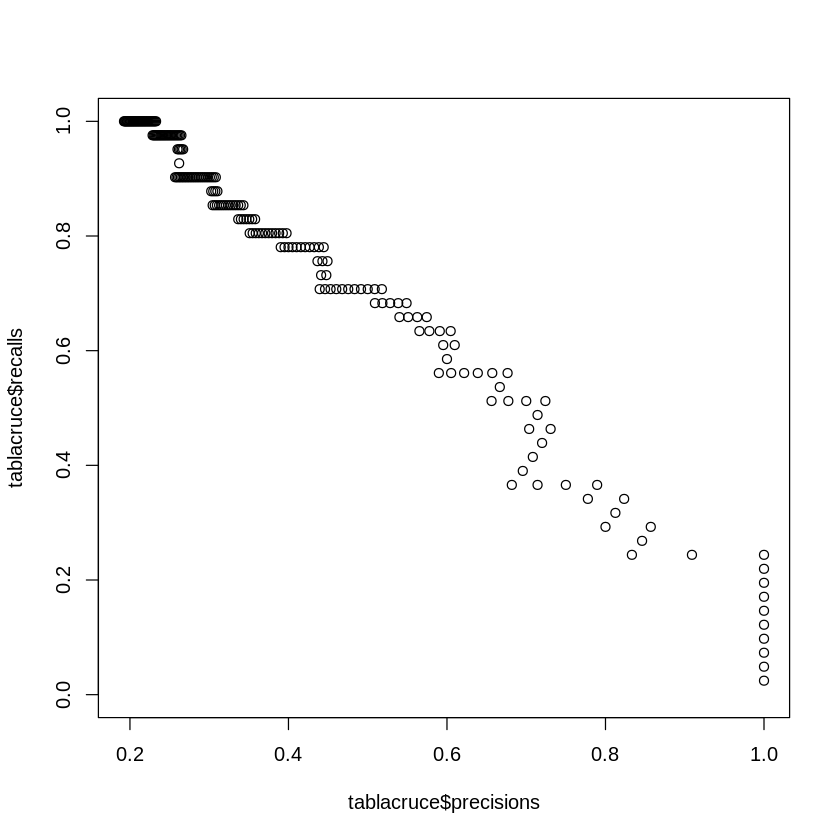

In [82]:

#ver precisiones versus exhaustividad
plot(tablacruce$precisions,tablacruce$recalls)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_point()`).”


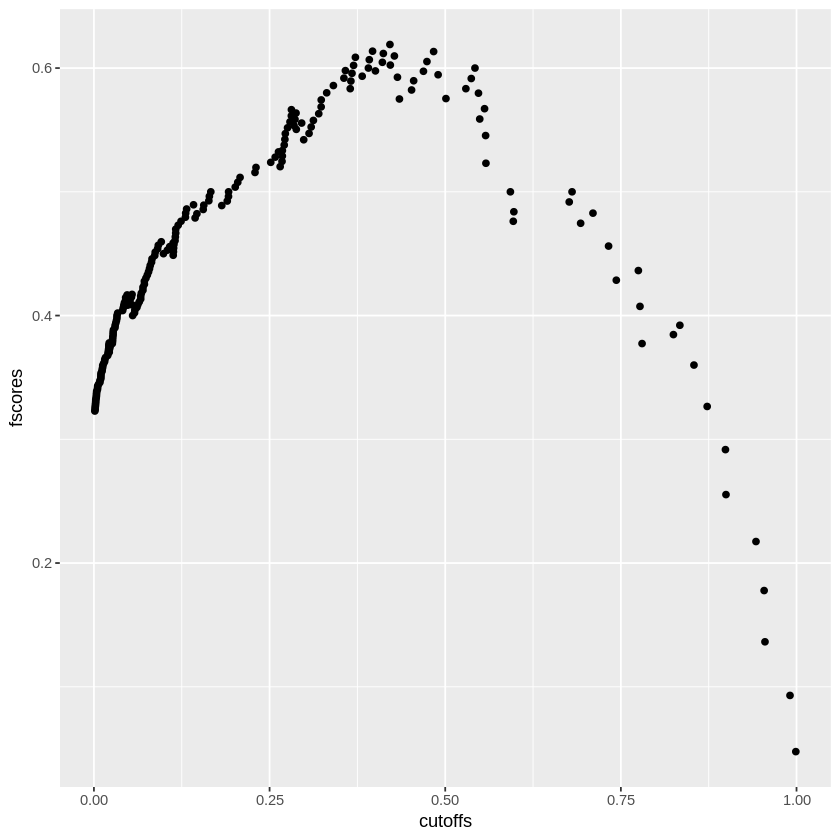

In [83]:
#ver el cutoff que maximiza f score
ggplot(tablacruce, aes(cutoffs,fscores))+geom_point()


In [84]:
#calcular las ganancias
tablacruce$ganancia<-prop.table(balance)[2]*recalls*(500-(100/precisions))

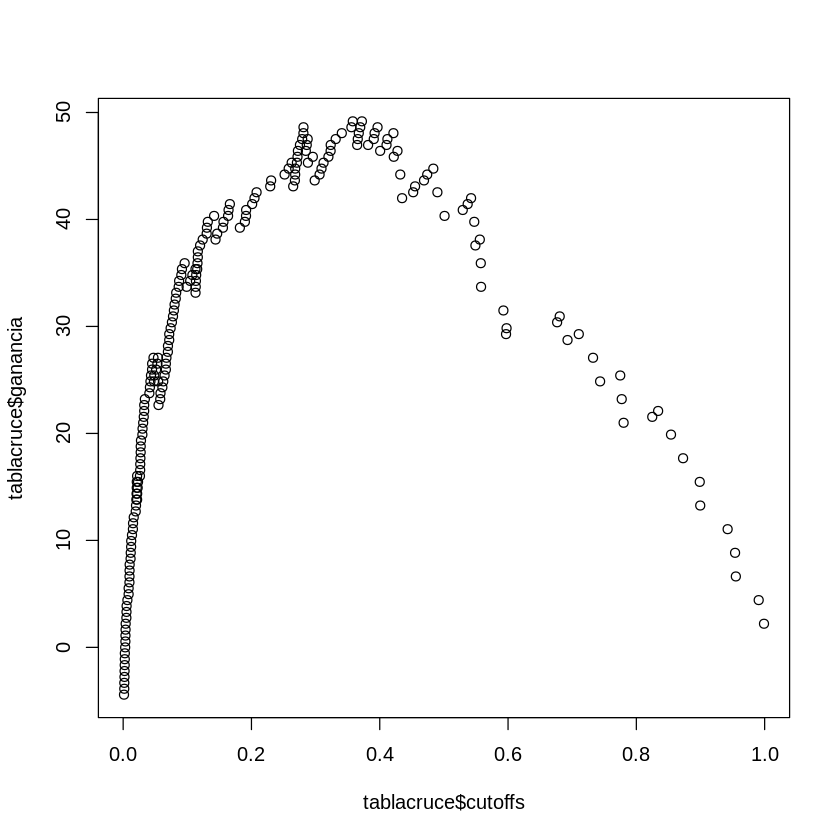

In [85]:
#pintar las ganancias versus los cutoffs
plot(tablacruce$cutoffs,tablacruce$ganancia)

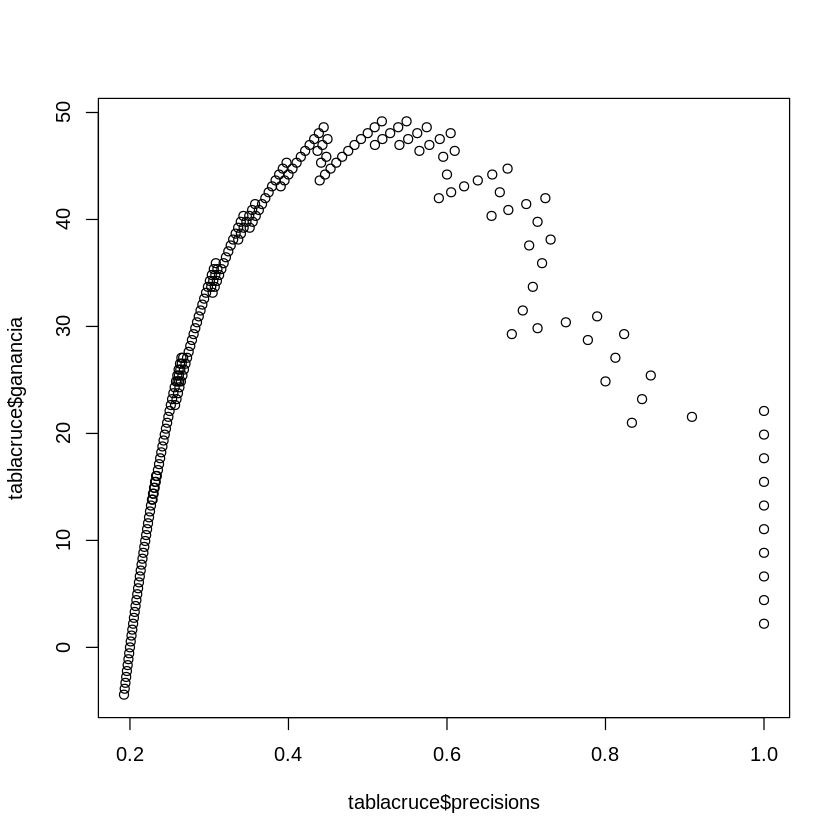

In [86]:
#ver las ganancias frente a la precisión
plot(tablacruce$precisions,tablacruce$ganancia)

La primera gráfica nos muestra la relación inversa entre precisiones y exhaustividades.

La segunda gráfica nos presenta las ganancias (por cliente) contra los puntos de corte, de modo que podemos escoger un punto de corte ideal, el cual está cercano al 0.40, de hecho en la base de datos es 0.3965.

La tercera gráfica nos muestra la relación de ganancias con precisones, donde es visible que no necesariamente la mayor precisión lleva a la mejor ganancia (por su baja exhaustividad)

Por supuesto, estos resultados dependen de la definición de ganancias y pérdidas. Si el costo de un cliente que incumple, por ejemplo, es del 70% frente a la ganancia que puede traer un cliente cumplido, entonces la precisión actual no es suficiente y debemos cambiar el punto de corte o buscar un balanceo de la base de datos que permita realizar mejores predicciones de incumplidos.

In [87]:
tablaver<-subset(tablacruce, tablacruce$cutoffs>0.2 & tablacruce$cutoffs<0.6)
View(tablaver)

,cutoffs,precisions,recalls,fscores,ganancia
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
734,0.5976775,0.7142857,0.3658537,0.4838710,29.83511
631,0.5968616,0.6818182,0.3658537,0.4761905,29.28261
785,0.5927569,0.6956522,0.3902439,0.5000000,31.49261
503,0.5579322,0.7083333,0.4146341,0.5230769,33.70262
450,0.5575003,0.7200000,0.4390244,0.5454545,35.91263
463,0.5559750,0.7307692,0.4634146,0.5671642,38.12264
360,0.5491245,0.7037037,0.4634146,0.5588235,37.57014
592,0.5473253,0.7142857,0.4878049,0.5797101,39.78014
426,0.5423453,0.7241379,0.5121951,0.6000000,41.99015


In [91]:
#crea el pronóstico en validación
probtest<-predict(steplogit,newdata = cartera.test,type='response')
prontest<-ifelse(probtest > 0.397,1,0)
conftest<-confusionMatrix(as.factor(prontest),cartera.test$retrasos, positive = "1")
conftest

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 122   7
         1  50  34
                                          
               Accuracy : 0.7324          
                 95% CI : (0.6676, 0.7906)
    No Information Rate : 0.8075          
    P-Value [Acc > NIR] : 0.9971          
                                          
                  Kappa : 0.3849          
                                          
 Mcnemar's Test P-Value : 2.651e-08       
                                          
            Sensitivity : 0.8293          
            Specificity : 0.7093          
         Pos Pred Value : 0.4048          
         Neg Pred Value : 0.9457          
             Prevalence : 0.1925          
         Detection Rate : 0.1596          
   Detection Prevalence : 0.3944          
      Balanced Accuracy : 0.7693          
                                          
       'Positive' Class : 1               
                              